In [8]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils   import class_weight

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

#folder_path = '/home/user/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rl_sim/thesis_ws/src/ML_Levers_Knobs/DATA/1D_TRANSF_KNOB_FTP_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

X_data = X_data[:, :, 4]

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000
N_CLASS = 6
DISP_LABELS = ["0", "1", "2", "3", "4", "5"]

X_data shape: (629, 2000)
y_data shape: (629,)
X_data.[0] shape:  (2000,)
TOTAL DATA: 629  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (377, 2000)    ||  Dimensions of y_train: (377,)
Dimensions of X_test:  (126, 2000)    ||  Dimensions of y_test:  (126,)
Dimensions of X_val:   (126, 2000)    ||  Dimensions of y_val:   (126,)


# 1 CONVs

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 496, 512)       │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 248, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 126976)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     8,126,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,137,670 (31.04 MB)

 Trainable params: 8,137,670 (31.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2172 - loss: 2.0497 - val_accuracy: 0.3492 - val_loss: 1.5759
Epoch 2/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4072 - loss: 1.3926 - val_accuracy: 0.5317 - val_loss: 1.1499
Epoch 3/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5572 - loss: 1.0252 - val_accuracy: 0.4524 - val_loss: 1.3725
Epoch 4/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5902 - loss: 0.9723 - val_accuracy: 0.5873 - val_loss: 1.0332
Epoch 5/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6377 - loss: 0.9396 - val_accuracy: 0.6746 - val_loss: 0.8043
Epoch 6/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6838 - loss: 0.7902 - val_accuracy: 0.6111 - val_loss: 0.9395
Epoch 7/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7243 - loss: 0.7141 - val_accuracy: 0.6508 - val_loss: 0.8185
Epoch 8/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.6098 - val_accuracy: 0.6667 - val_loss: 0.8364
Ep

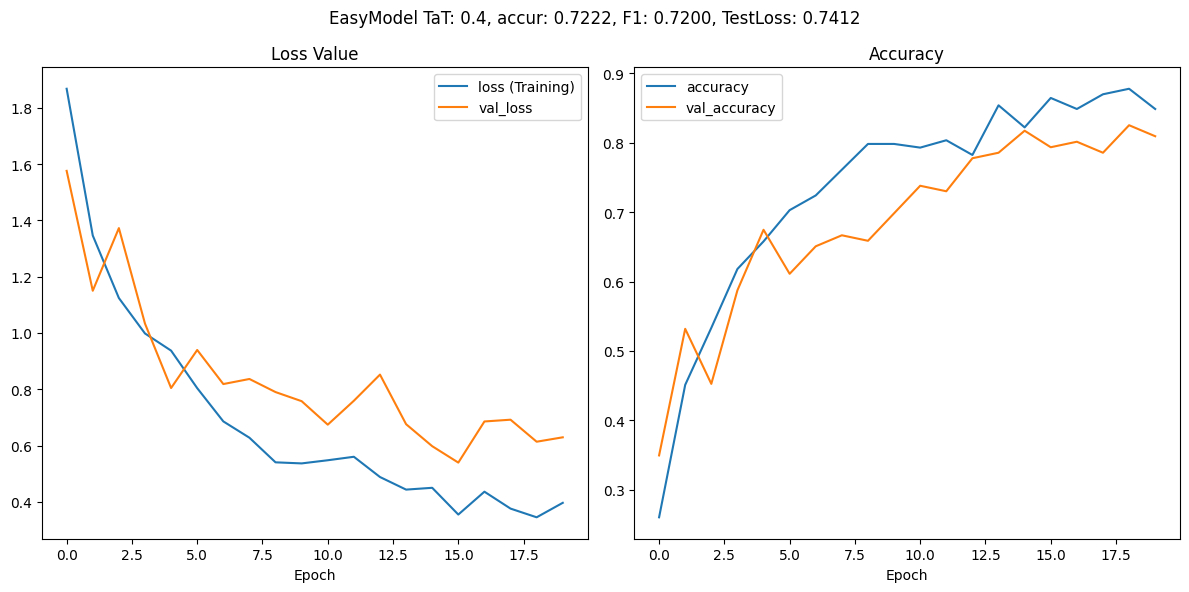

Train loss: 0.39648592472076416
Test val_loss: 0.6292310357093811
Train accuracy: 0.8488063812255859
Accuracy Score: 0.7222222222222222
F1 Score: 0.7200021200021199
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.86      0.82        21
         1.0       0.77      0.77      0.77        39
         2.0       0.67      0.48      0.56        21
         3.0       0.91      0.91      0.91        11
         4.0       0.71      0.94      0.81        16
         5.0       0.47      0.44      0.46        18

    accuracy                           0.72       126
   macro avg       0.72      0.73      0.72       126
weighted avg       0.72      0.72      0.71       126



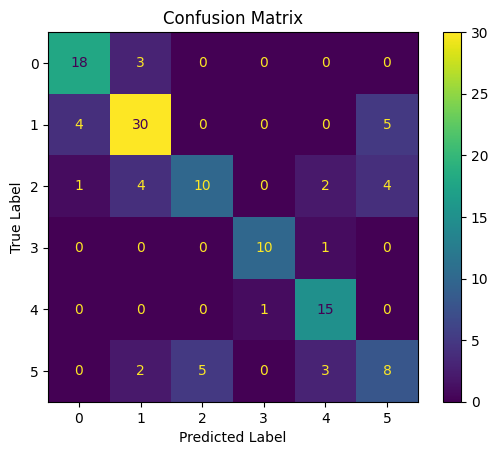

In [9]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=20, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=22, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights,verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels, zero_division=0))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 197, 512)       │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 194, 128)       │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,910 (1.11 MB)

 Trainable params: 291,910 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1855 - loss: 1.8347 - val_accuracy: 0.0952 - val_loss: 1.7846
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2109 - loss: 1.7985 - val_accuracy: 0.2937 - val_loss: 1.8203
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3124 - loss: 1.7438 - val_accuracy: 0.4127 - val_loss: 1.5433
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4085 - loss: 1.5822 - val_accuracy: 0.3095 - val_loss: 1.5981
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3479 - loss: 1.6099 - val_accuracy: 0.4206 - val_loss: 1.4806
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3339 - loss: 1.4980 - val_accuracy: 0.4206 - val_loss: 1.4315
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3700 - loss: 1.4342 - val_accuracy: 0.4444 - val_loss: 1.3292
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4184 - loss: 1.3669 - val_accuracy: 0.3968 - val_loss: 1.3295
Ep

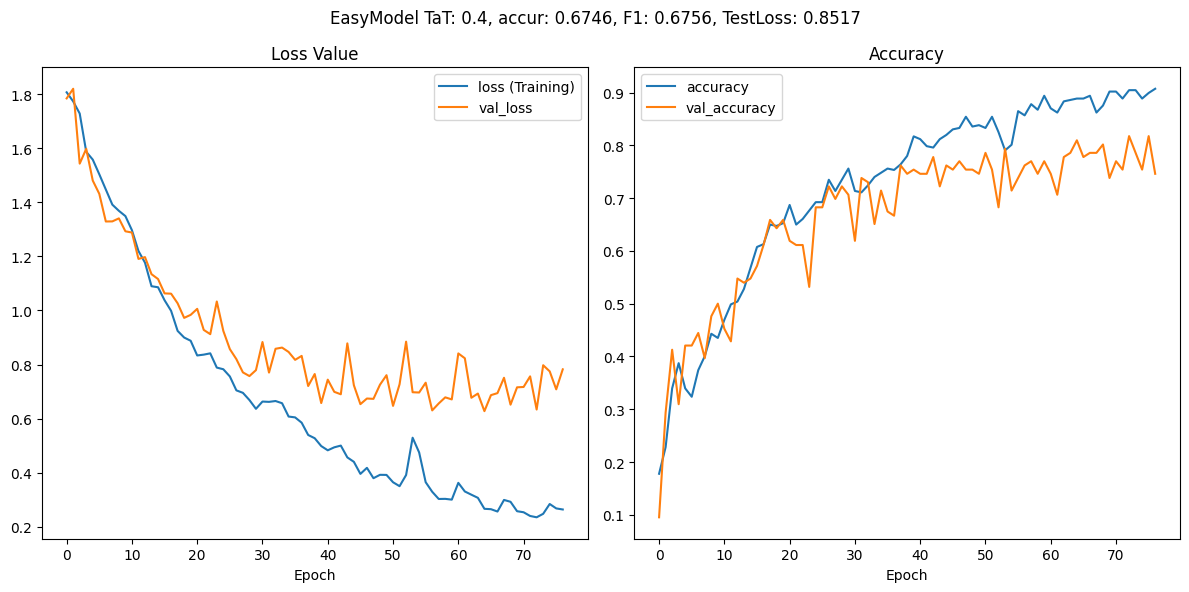

Train loss: 0.2635287642478943
Test val_loss: 0.7820950746536255
Train accuracy: 0.9071618318557739
Accuracy Score: 0.6746031746031746
F1 Score: 0.6755555555555555
Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.95      0.83        21
         1.0       0.70      0.59      0.64        39
         2.0       0.89      0.38      0.53        21
         3.0       0.64      0.82      0.72        11
         4.0       0.75      0.75      0.75        16
         5.0       0.48      0.72      0.58        18

    accuracy                           0.67       126
   macro avg       0.70      0.70      0.68       126
weighted avg       0.71      0.67      0.67       126



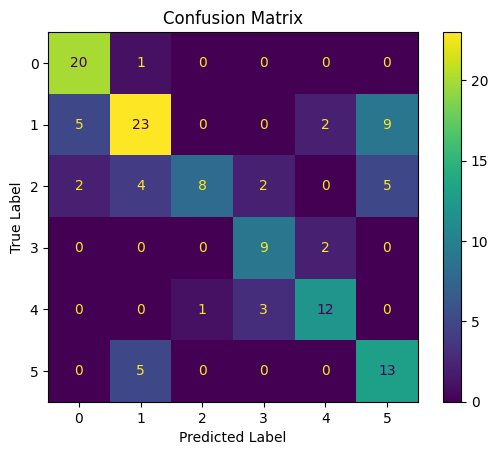

In [10]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=40, strides=10, activation='relu', input_shape=(WS_B, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights,verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels, zero_division=.000))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2 CONV with K-Fold to reduce problems about unbalaced Data. BAD PErformances

In [11]:
# import numpy as np
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.utils import class_weight
# from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
# from sklearn.model_selection import StratifiedKFold
# import matplotlib.pyplot as plt
# import os

# # Assuming WS_B is the input length for your model (e.g., 2000)
# WS_B = 2000

# # Define the model
# def build_easyModel():
#     model = Sequential()
#     model.add(Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', input_shape=(WS_B, 1)))
#     model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(N_CLASS, activation='softmax'))
#     return model


# X, y = X_data, y_data

# # Prepare for k-fold cross-validation
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold_no = 1
# results = []

# for train_index, test_index in kfold.split(X, y):
#     print(f'Training fold {fold_no}...')
    
#     # Split data
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # Calculate class weights
#     class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#     class_weights = {i: class_weights[i] for i in range(len(class_weights))}

#     # Build and compile the model
#     model = build_easyModel()
#     model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
#     history = model.fit(X_train, y_train, epochs=22, batch_size=32, validation_split=0.2, class_weight=class_weights, verbose=1, callbacks=[early_stopping])

#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test)

#     # Predict labels for test data
#     y_pred = model.predict(X_test)
#     y_pred_labels = np.argmax(y_pred, axis=1)

#     f1 = f1_score(y_test, y_pred_labels, average='macro')
#     accuracy = accuracy_score(y_test, y_pred_labels)

#     print(f'Fold {fold_no} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
    
#     results.append((loss, accuracy, f1))

#     # Plot the results for this fold
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Plot Loss Value
#     axs[0].plot(history.history["loss"], label="loss (Training)")
#     axs[0].plot(history.history["val_loss"], label="val_loss")
#     axs[0].set_title(f"Loss Value (Fold {fold_no})")
#     axs[0].set_xlabel('Epoch')
#     axs[0].legend()

#     # Plot Accuracy
#     axs[1].plot(history.history["accuracy"], label="accuracy")
#     axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
#     axs[1].set_title(f"Accuracy (Fold {fold_no})")
#     axs[1].set_xlabel('Epoch')
#     axs[1].legend()

#     plt.suptitle(f"Fold {fold_no}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Test Loss: {loss:.4f}")
#     plt.tight_layout()
#     plt.show()

#     # Print evaluation metrics for this fold
#     print(f"Fold {fold_no} Train loss:", history.history["loss"][-1])
#     print(f"Fold {fold_no} Test val_loss:", history.history["val_loss"][-1])
#     print(f"Fold {fold_no} Train accuracy:", history.history["accuracy"][-1])
#     print(f"Fold {fold_no} Accuracy Score:", accuracy)
#     print(f"Fold {fold_no} F1 Score:", f1)
#     print(f"Fold {fold_no} Classification Report:\n", classification_report(y_test, y_pred_labels, zero_division=0))

#     # Plot the confusion matrix for this fold
#     conf_mat = confusion_matrix(y_test, y_pred_labels)
#     disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix (Fold {fold_no})')
#     plt.show()

#     fold_no += 1

# # Calculate average results
# average_loss = np.mean([result[0] for result in results])
# average_accuracy = np.mean([result[1] for result in results])
# average_f1 = np.mean([result[2] for result in results])

# print(f'Average Loss: {average_loss:.4f}')
# print(f'Average Accuracy: {average_accuracy:.4f}')
# print(f'Average F1 Score: {average_f1:.4f}')


# 3 CONVs

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 498, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 123, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 122, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,062 (519.77 KB)

 Trainable params: 133,062 (519.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.2057 - loss: 1.7427 - val_accuracy: 0.3492 - val_loss: 1.6655
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3090 - loss: 1.6835 - val_accuracy: 0.3571 - val_loss: 1.6327
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3658 - loss: 1.5637 - val_accuracy: 0.3730 - val_loss: 1.5620
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3694 - loss: 1.5385 - val_accuracy: 0.3889 - val_loss: 1.4988
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4000 - loss: 1.4631 - val_accuracy: 0.4048 - val_loss: 1.4299
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3864 - loss: 1.4900 - val_accuracy: 0.4286 - val_loss: 1.3669
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4551 - loss: 1.3406 - val_accuracy: 0.4206 - val_loss: 1.3372
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4295 - loss: 1.3656 - val_accuracy: 0.4841 - val_loss: 1

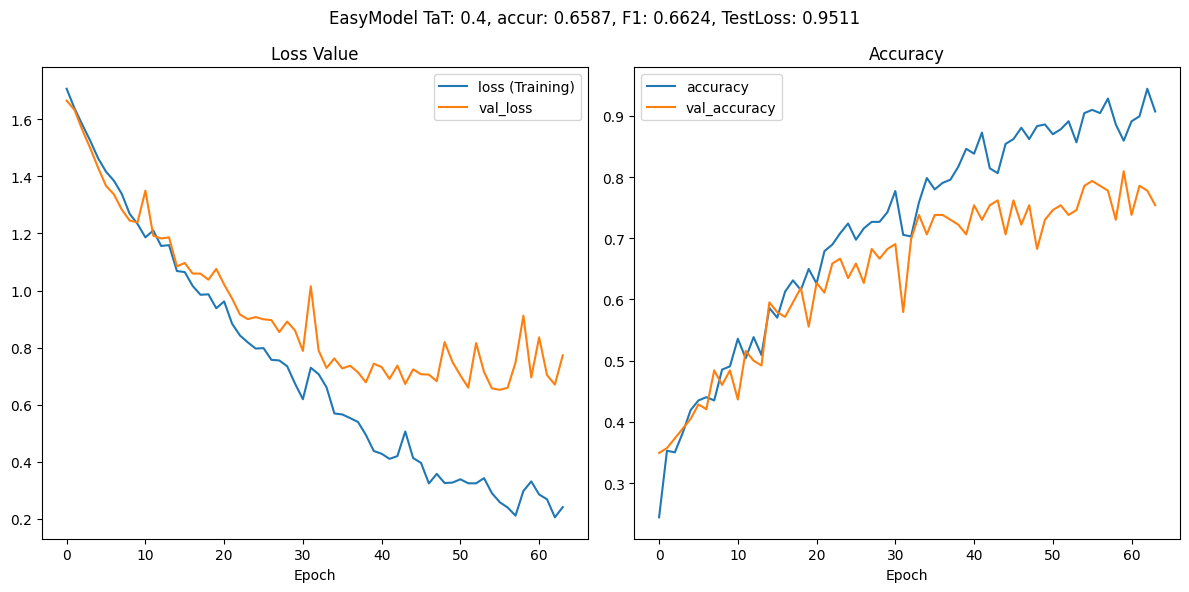

Train loss: 0.24141041934490204
Test val_loss: 0.7731828093528748
Train accuracy: 0.9071618318557739
Accuracy Score: 0.6587301587301587
F1 Score: 0.6623841855418043
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.90      0.84        21
         1.0       0.81      0.56      0.67        39
         2.0       0.55      0.52      0.54        21
         3.0       0.62      0.91      0.74        11
         4.0       0.73      0.69      0.71        16
         5.0       0.42      0.56      0.48        18

    accuracy                           0.66       126
   macro avg       0.66      0.69      0.66       126
weighted avg       0.68      0.66      0.66       126



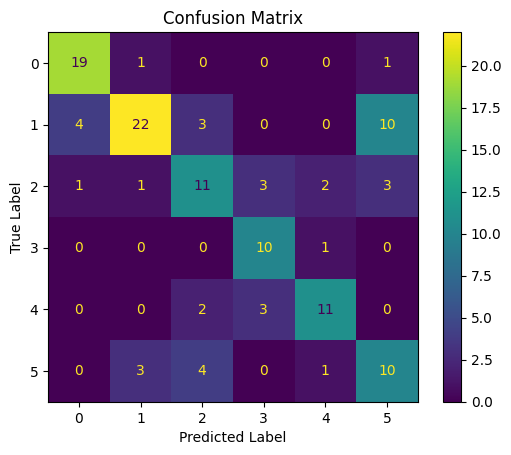

In [12]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=10, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=4, strides=2, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_CLASS, activation='softmax'))

    return model
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4 CONVs or Still "COMPLEX"

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 996, 256)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 498, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 248, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 248, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 120, 128)       │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 57, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,406 (2.40 MB)

 Trainable params: 630,406 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.2242 - loss: 1.7495 - val_accuracy: 0.2937 - val_loss: 1.6943
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3195 - loss: 1.6616 - val_accuracy: 0.2778 - val_loss: 1.6802
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3667 - loss: 1.6297 - val_accuracy: 0.3571 - val_loss: 1.6674
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3642 - loss: 1.5928 - val_accuracy: 0.3333 - val_loss: 1.6268
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4027 - loss: 1.5428 - val_accuracy: 0.4206 - val_loss: 1.5001
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4064 - loss: 1.4175 - val_accuracy: 0.3333 - val_loss: 1.5202
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4572 - loss: 1.3370 - val_accuracy: 0.4762 - val_loss: 1.4328
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4357 - loss: 1.3820 - val_accuracy: 0.4921 - val_los

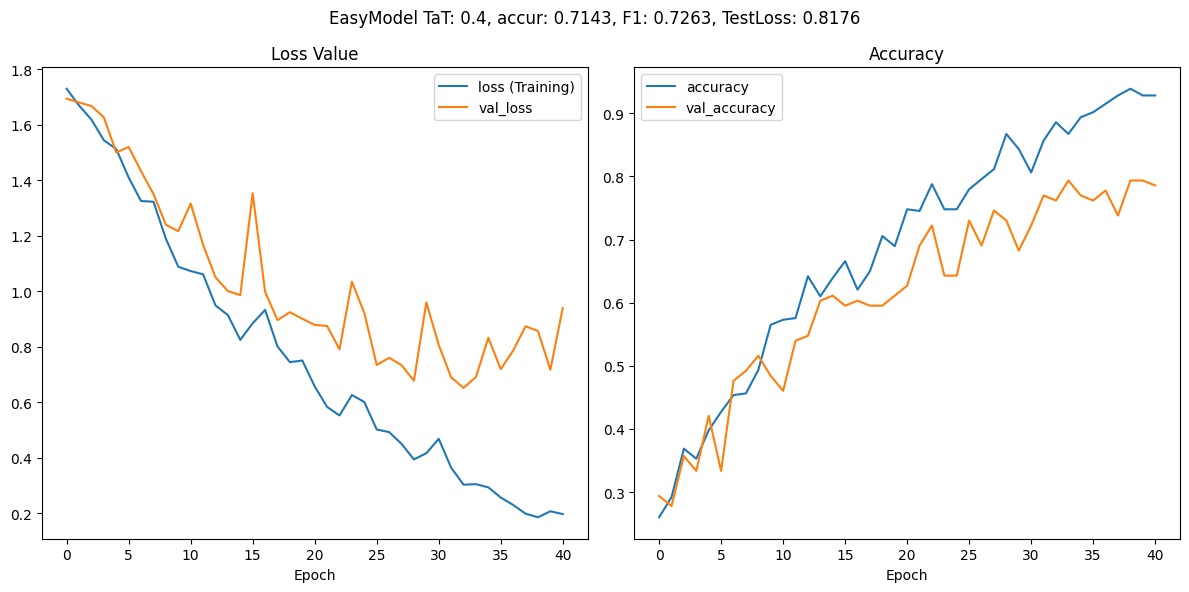

Train loss: 0.19776394963264465
Test val_loss: 0.9397244453430176
Train accuracy: 0.9283819794654846
Accuracy Score: 0.7142857142857143
F1 Score: 0.72628253864813
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.90      0.84        21
         1.0       0.73      0.62      0.67        39
         2.0       0.92      0.52      0.67        21
         3.0       0.69      1.00      0.81        11
         4.0       0.80      0.75      0.77        16
         5.0       0.50      0.72      0.59        18

    accuracy                           0.71       126
   macro avg       0.74      0.75      0.73       126
weighted avg       0.74      0.71      0.71       126



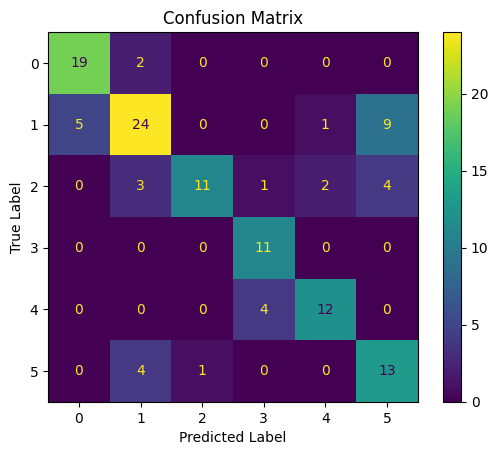

In [13]:
def build_easyModel():
    model = Sequential()
    
    model.add(Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=256, kernel_size=4, strides=2, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(filters=128, kernel_size=10, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 CONVS